In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : True,
    'balance_bins'  : 40,
    'balance_ratio' : 1,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_40_1_1_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 828)
(631390, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:38 - loss: 0.1678 - STD: 1.5321e-04 - MAE: 0.3963

 4/64 [>.............................] - ETA: 1s - loss: 0.0596 - STD: 5.6299e-04 - MAE: 0.1846  

 5/64 [=>............................] - ETA: 2s - loss: 0.0537 - STD: 5.0018e-04 - MAE: 0.1746

 6/64 [=>............................] - ETA: 2s - loss: 0.0505 - STD: 4.4126e-04 - MAE: 0.1703

 7/64 [==>...........................] - ETA: 2s - loss: 0.0488 - STD: 3.9097e-04 - MAE: 0.1688

 8/64 [==>...........................] - ETA: 2s - loss: 0.0476 - STD: 3.4962e-04 - MAE: 0.1680

 9/64 [===>..........................] - ETA: 2s - loss: 0.0464 - STD: 3.1635e-04 - MAE: 0.1669

10/64 [===>..........................] - ETA: 2s - loss: 0.0455 - STD: 2.8993e-04 - MAE: 0.1657

11/64 [====>.........................] - ETA: 2s - loss: 0.0445 - STD: 2.6924e-04 - MAE: 0.1640

12/64 [====>.........................] - ETA: 2s - loss: 0.0433 - STD: 2.5296e-04 - MAE: 0.1616

13/64 [=====>........................] - ETA: 2s - loss: 0.0421 - STD: 2.4034e-04 - MAE: 0.1586

14/64 [=====>........................] - ETA: 2s - loss: 0.0408 - STD: 2.3062e-04 - MAE: 0.1548

15/64 [======>.......................] - ETA: 2s - loss: 0.0395 - STD: 2.2335e-04 - MAE: 0.1504

16/64 [======>.......................] - ETA: 2s - loss: 0.0380 - STD: 2.1787e-04 - MAE: 0.1452

17/64 [======>.......................] - ETA: 2s - loss: 0.0366 - STD: 2.1388e-04 - MAE: 0.1403

18/64 [=======>......................] - ETA: 2s - loss: 0.0353 - STD: 2.1097e-04 - MAE: 0.1363

19/64 [=======>......................] - ETA: 2s - loss: 0.0341 - STD: 2.0873e-04 - MAE: 0.1337

20/64 [========>.....................] - ETA: 2s - loss: 0.0332 - STD: 2.0693e-04 - MAE: 0.1322

21/64 [========>.....................] - ETA: 2s - loss: 0.0324 - STD: 2.0526e-04 - MAE: 0.1313

22/64 [=========>....................] - ETA: 2s - loss: 0.0318 - STD: 2.0361e-04 - MAE: 0.1309

23/64 [=========>....................] - ETA: 2s - loss: 0.0312 - STD: 2.0198e-04 - MAE: 0.1304

24/64 [==========>...................] - ETA: 2s - loss: 0.0306 - STD: 2.0035e-04 - MAE: 0.1298

25/64 [==========>...................] - ETA: 2s - loss: 0.0300 - STD: 1.9867e-04 - MAE: 0.1288

26/64 [===========>..................] - ETA: 2s - loss: 0.0293 - STD: 1.9681e-04 - MAE: 0.1274

27/64 [===========>..................] - ETA: 1s - loss: 0.0287 - STD: 1.9492e-04 - MAE: 0.1258

28/64 [============>.................] - ETA: 1s - loss: 0.0281 - STD: 1.9292e-04 - MAE: 0.1238

29/64 [============>.................] - ETA: 1s - loss: 0.0276 - STD: 1.9086e-04 - MAE: 0.1219

30/64 [=============>................] - ETA: 1s - loss: 0.0271 - STD: 1.8875e-04 - MAE: 0.1198

31/64 [=============>................] - ETA: 1s - loss: 0.0267 - STD: 1.8676e-04 - MAE: 0.1178

32/64 [==============>...............] - ETA: 1s - loss: 0.0263 - STD: 1.8480e-04 - MAE: 0.1161

33/64 [==============>...............] - ETA: 1s - loss: 0.0259 - STD: 1.8301e-04 - MAE: 0.1144

34/64 [==============>...............] - ETA: 2s - loss: 0.0259 - STD: 1.8120e-04 - MAE: 0.1128

37/64 [================>.............] - ETA: 1s - loss: 0.0249 - STD: 1.7742e-04 - MAE: 0.1086

39/64 [=================>............] - ETA: 1s - loss: 0.0243 - STD: 1.7611e-04 - MAE: 0.1062

40/64 [=================>............] - ETA: 1s - loss: 0.0240 - STD: 1.7582e-04 - MAE: 0.1052

41/64 [==================>...........] - ETA: 1s - loss: 0.0237 - STD: 1.7578e-04 - MAE: 0.1044

42/64 [==================>...........] - ETA: 1s - loss: 0.0235 - STD: 1.7598e-04 - MAE: 0.1037

43/64 [===================>..........] - ETA: 1s - loss: 0.0232 - STD: 1.7631e-04 - MAE: 0.1031

44/64 [===================>..........] - ETA: 1s - loss: 0.0230 - STD: 1.7683e-04 - MAE: 0.1026

45/64 [====================>.........] - ETA: 1s - loss: 0.0228 - STD: 1.7754e-04 - MAE: 0.1022

46/64 [====================>.........] - ETA: 1s - loss: 0.0226 - STD: 1.7832e-04 - MAE: 0.1019

47/64 [=====================>........] - ETA: 1s - loss: 0.0224 - STD: 1.7922e-04 - MAE: 0.1015

48/64 [=====================>........] - ETA: 1s - loss: 0.0222 - STD: 1.8014e-04 - MAE: 0.1011

49/64 [=====================>........] - ETA: 0s - loss: 0.0220 - STD: 1.8111e-04 - MAE: 0.1006

50/64 [======================>.......] - ETA: 0s - loss: 0.0218 - STD: 1.8214e-04 - MAE: 0.1001

51/64 [======================>.......] - ETA: 0s - loss: 0.0216 - STD: 1.8317e-04 - MAE: 0.0995

52/64 [=======================>......] - ETA: 0s - loss: 0.0214 - STD: 1.8425e-04 - MAE: 0.0989

53/64 [=======================>......] - ETA: 0s - loss: 0.0212 - STD: 1.8537e-04 - MAE: 0.0983

54/64 [========================>.....] - ETA: 0s - loss: 0.0211 - STD: 1.8655e-04 - MAE: 0.0977

55/64 [========================>.....] - ETA: 0s - loss: 0.0209 - STD: 1.8779e-04 - MAE: 0.0971

56/64 [=========================>....] - ETA: 0s - loss: 0.0208 - STD: 1.8916e-04 - MAE: 0.0965

57/64 [=========================>....] - ETA: 0s - loss: 0.0206 - STD: 1.9067e-04 - MAE: 0.0959

58/64 [==========================>...] - ETA: 0s - loss: 0.0205 - STD: 1.9225e-04 - MAE: 0.0953

59/64 [==========================>...] - ETA: 0s - loss: 0.0204 - STD: 1.9403e-04 - MAE: 0.0948

60/64 [===========================>..] - ETA: 0s - loss: 0.0202 - STD: 1.9600e-04 - MAE: 0.0943

61/64 [===========================>..] - ETA: 0s - loss: 0.0201 - STD: 1.9818e-04 - MAE: 0.0939

62/64 [============================>.] - ETA: 0s - loss: 0.0200 - STD: 2.0054e-04 - MAE: 0.0935

63/64 [============================>.] - ETA: 0s - loss: 0.0199 - STD: 2.0316e-04 - MAE: 0.0931

64/64 [==============================] - ETA: 0s - loss: 0.0198 - STD: 2.0596e-04 - MAE: 0.0928

64/64 [==============================] - 6s 74ms/step - loss: 0.0198 - STD: 2.0596e-04 - MAE: 0.0928 - val_loss: 0.0166 - val_STD: 2.9670e-04 - val_MAE: 0.0828


Epoch 2/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0126 - STD: 3.9602e-04 - MAE: 0.0731

 2/64 [..............................] - ETA: 4s - loss: 0.0125 - STD: 4.0526e-04 - MAE: 0.0734

 3/64 [>.............................] - ETA: 4s - loss: 0.0126 - STD: 4.1614e-04 - MAE: 0.0741

 4/64 [>.............................] - ETA: 4s - loss: 0.0125 - STD: 4.2436e-04 - MAE: 0.0740

 5/64 [=>............................] - ETA: 3s - loss: 0.0126 - STD: 4.3400e-04 - MAE: 0.0740

 6/64 [=>............................] - ETA: 3s - loss: 0.0126 - STD: 4.4320e-04 - MAE: 0.0741

 7/64 [==>...........................] - ETA: 3s - loss: 0.0127 - STD: 4.5211e-04 - MAE: 0.0739

 8/64 [==>...........................] - ETA: 3s - loss: 0.0127 - STD: 4.6154e-04 - MAE: 0.0734

 9/64 [===>..........................] - ETA: 3s - loss: 0.0127 - STD: 4.7123e-04 - MAE: 0.0731

10/64 [===>..........................] - ETA: 3s - loss: 0.0127 - STD: 4.8098e-04 - MAE: 0.0726

11/64 [====>.........................] - ETA: 3s - loss: 0.0127 - STD: 4.9162e-04 - MAE: 0.0723

12/64 [====>.........................] - ETA: 3s - loss: 0.0127 - STD: 5.0235e-04 - MAE: 0.0720

13/64 [=====>........................] - ETA: 3s - loss: 0.0127 - STD: 5.1362e-04 - MAE: 0.0717

14/64 [=====>........................] - ETA: 3s - loss: 0.0127 - STD: 5.2567e-04 - MAE: 0.0714

15/64 [======>.......................] - ETA: 3s - loss: 0.0127 - STD: 5.3866e-04 - MAE: 0.0711

16/64 [======>.......................] - ETA: 3s - loss: 0.0127 - STD: 5.5246e-04 - MAE: 0.0709

17/64 [======>.......................] - ETA: 3s - loss: 0.0127 - STD: 5.6738e-04 - MAE: 0.0708

18/64 [=======>......................] - ETA: 3s - loss: 0.0127 - STD: 5.8272e-04 - MAE: 0.0707

19/64 [=======>......................] - ETA: 2s - loss: 0.0127 - STD: 5.9916e-04 - MAE: 0.0708

20/64 [========>.....................] - ETA: 2s - loss: 0.0127 - STD: 6.1668e-04 - MAE: 0.0708

21/64 [========>.....................] - ETA: 2s - loss: 0.0127 - STD: 6.3499e-04 - MAE: 0.0709

22/64 [=========>....................] - ETA: 2s - loss: 0.0127 - STD: 6.5399e-04 - MAE: 0.0709

23/64 [=========>....................] - ETA: 2s - loss: 0.0127 - STD: 6.7389e-04 - MAE: 0.0708

24/64 [==========>...................] - ETA: 2s - loss: 0.0127 - STD: 6.9533e-04 - MAE: 0.0709

25/64 [==========>...................] - ETA: 2s - loss: 0.0127 - STD: 7.1723e-04 - MAE: 0.0709

26/64 [===========>..................] - ETA: 2s - loss: 0.0126 - STD: 7.3991e-04 - MAE: 0.0708

27/64 [===========>..................] - ETA: 2s - loss: 0.0126 - STD: 7.6379e-04 - MAE: 0.0708

28/64 [============>.................] - ETA: 2s - loss: 0.0126 - STD: 7.8916e-04 - MAE: 0.0707

29/64 [============>.................] - ETA: 2s - loss: 0.0126 - STD: 8.1533e-04 - MAE: 0.0706

30/64 [=============>................] - ETA: 2s - loss: 0.0126 - STD: 8.4299e-04 - MAE: 0.0705

31/64 [=============>................] - ETA: 2s - loss: 0.0126 - STD: 8.7229e-04 - MAE: 0.0704

32/64 [==============>...............] - ETA: 2s - loss: 0.0126 - STD: 9.0331e-04 - MAE: 0.0704

33/64 [==============>...............] - ETA: 2s - loss: 0.0126 - STD: 9.3650e-04 - MAE: 0.0703

35/64 [===============>..............] - ETA: 1s - loss: 0.0126 - STD: 0.0010 - MAE: 0.0702    

36/64 [===============>..............] - ETA: 1s - loss: 0.0126 - STD: 0.0010 - MAE: 0.0702

37/64 [================>.............] - ETA: 1s - loss: 0.0126 - STD: 0.0011 - MAE: 0.0702

38/64 [================>.............] - ETA: 1s - loss: 0.0126 - STD: 0.0011 - MAE: 0.0702

39/64 [=================>............] - ETA: 1s - loss: 0.0126 - STD: 0.0012 - MAE: 0.0702

40/64 [=================>............] - ETA: 1s - loss: 0.0125 - STD: 0.0012 - MAE: 0.0702

41/64 [==================>...........] - ETA: 1s - loss: 0.0125 - STD: 0.0013 - MAE: 0.0702

42/64 [==================>...........] - ETA: 1s - loss: 0.0125 - STD: 0.0013 - MAE: 0.0701

43/64 [===================>..........] - ETA: 1s - loss: 0.0125 - STD: 0.0014 - MAE: 0.0701

44/64 [===================>..........] - ETA: 1s - loss: 0.0125 - STD: 0.0015 - MAE: 0.0701

45/64 [====================>.........] - ETA: 1s - loss: 0.0125 - STD: 0.0015 - MAE: 0.0700

46/64 [====================>.........] - ETA: 1s - loss: 0.0125 - STD: 0.0016 - MAE: 0.0700

47/64 [=====================>........] - ETA: 1s - loss: 0.0125 - STD: 0.0017 - MAE: 0.0699

48/64 [=====================>........] - ETA: 1s - loss: 0.0125 - STD: 0.0017 - MAE: 0.0699

49/64 [=====================>........] - ETA: 0s - loss: 0.0125 - STD: 0.0018 - MAE: 0.0698

50/64 [======================>.......] - ETA: 0s - loss: 0.0124 - STD: 0.0019 - MAE: 0.0697

51/64 [======================>.......] - ETA: 0s - loss: 0.0124 - STD: 0.0020 - MAE: 0.0697

52/64 [=======================>......] - ETA: 0s - loss: 0.0124 - STD: 0.0021 - MAE: 0.0696

53/64 [=======================>......] - ETA: 0s - loss: 0.0124 - STD: 0.0022 - MAE: 0.0696

54/64 [========================>.....] - ETA: 0s - loss: 0.0124 - STD: 0.0023 - MAE: 0.0695

55/64 [========================>.....] - ETA: 0s - loss: 0.0123 - STD: 0.0025 - MAE: 0.0694

56/64 [=========================>....] - ETA: 0s - loss: 0.0123 - STD: 0.0026 - MAE: 0.0693

57/64 [=========================>....] - ETA: 0s - loss: 0.0123 - STD: 0.0027 - MAE: 0.0693

58/64 [==========================>...] - ETA: 0s - loss: 0.0123 - STD: 0.0029 - MAE: 0.0692

59/64 [==========================>...] - ETA: 0s - loss: 0.0123 - STD: 0.0030 - MAE: 0.0691

60/64 [===========================>..] - ETA: 0s - loss: 0.0122 - STD: 0.0032 - MAE: 0.0690

61/64 [===========================>..] - ETA: 0s - loss: 0.0122 - STD: 0.0034 - MAE: 0.0690

62/64 [============================>.] - ETA: 0s - loss: 0.0122 - STD: 0.0036 - MAE: 0.0689

63/64 [============================>.] - ETA: 0s - loss: 0.0121 - STD: 0.0038 - MAE: 0.0688

64/64 [==============================] - ETA: 0s - loss: 0.0121 - STD: 0.0040 - MAE: 0.0687

64/64 [==============================] - 4s 66ms/step - loss: 0.0121 - STD: 0.0040 - MAE: 0.0687 - val_loss: 0.0136 - val_STD: 0.0133 - val_MAE: 0.0702


Epoch 3/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0103 - STD: 0.0186 - MAE: 0.0623

 2/64 [..............................] - ETA: 3s - loss: 0.0104 - STD: 0.0193 - MAE: 0.0625

 3/64 [>.............................] - ETA: 3s - loss: 0.0102 - STD: 0.0200 - MAE: 0.0619

 4/64 [>.............................] - ETA: 3s - loss: 0.0099 - STD: 0.0207 - MAE: 0.0612

 5/64 [=>............................] - ETA: 3s - loss: 0.0099 - STD: 0.0215 - MAE: 0.0610

 6/64 [=>............................] - ETA: 3s - loss: 0.0098 - STD: 0.0223 - MAE: 0.0607

 7/64 [==>...........................] - ETA: 3s - loss: 0.0096 - STD: 0.0231 - MAE: 0.0603

 8/64 [==>...........................] - ETA: 3s - loss: 0.0095 - STD: 0.0240 - MAE: 0.0599

 9/64 [===>..........................] - ETA: 3s - loss: 0.0094 - STD: 0.0249 - MAE: 0.0595

10/64 [===>..........................] - ETA: 3s - loss: 0.0093 - STD: 0.0258 - MAE: 0.0590

11/64 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 0.0267 - MAE: 0.0587

12/64 [====>.........................] - ETA: 3s - loss: 0.0091 - STD: 0.0277 - MAE: 0.0582

13/64 [=====>........................] - ETA: 3s - loss: 0.0089 - STD: 0.0287 - MAE: 0.0578

14/64 [=====>........................] - ETA: 3s - loss: 0.0088 - STD: 0.0297 - MAE: 0.0573

15/64 [======>.......................] - ETA: 3s - loss: 0.0087 - STD: 0.0308 - MAE: 0.0569

16/64 [======>.......................] - ETA: 2s - loss: 0.0086 - STD: 0.0319 - MAE: 0.0565

17/64 [======>.......................] - ETA: 2s - loss: 0.0085 - STD: 0.0330 - MAE: 0.0560

18/64 [=======>......................] - ETA: 2s - loss: 0.0083 - STD: 0.0341 - MAE: 0.0555

19/64 [=======>......................] - ETA: 2s - loss: 0.0082 - STD: 0.0352 - MAE: 0.0551

20/64 [========>.....................] - ETA: 2s - loss: 0.0081 - STD: 0.0364 - MAE: 0.0546

21/64 [========>.....................] - ETA: 2s - loss: 0.0080 - STD: 0.0376 - MAE: 0.0542

22/64 [=========>....................] - ETA: 2s - loss: 0.0078 - STD: 0.0386 - MAE: 0.0537

23/64 [=========>....................] - ETA: 2s - loss: 0.0077 - STD: 0.0398 - MAE: 0.0533

24/64 [==========>...................] - ETA: 2s - loss: 0.0076 - STD: 0.0409 - MAE: 0.0529

25/64 [==========>...................] - ETA: 2s - loss: 0.0075 - STD: 0.0421 - MAE: 0.0525

26/64 [===========>..................] - ETA: 2s - loss: 0.0074 - STD: 0.0432 - MAE: 0.0520

27/64 [===========>..................] - ETA: 2s - loss: 0.0073 - STD: 0.0443 - MAE: 0.0516

28/64 [============>.................] - ETA: 2s - loss: 0.0071 - STD: 0.0454 - MAE: 0.0512

29/64 [============>.................] - ETA: 2s - loss: 0.0070 - STD: 0.0466 - MAE: 0.0508

30/64 [=============>................] - ETA: 2s - loss: 0.0070 - STD: 0.0477 - MAE: 0.0505

31/64 [=============>................] - ETA: 2s - loss: 0.0069 - STD: 0.0488 - MAE: 0.0501

32/64 [==============>...............] - ETA: 2s - loss: 0.0068 - STD: 0.0498 - MAE: 0.0498

33/64 [==============>...............] - ETA: 1s - loss: 0.0067 - STD: 0.0509 - MAE: 0.0494

34/64 [==============>...............] - ETA: 1s - loss: 0.0066 - STD: 0.0519 - MAE: 0.0491

35/64 [===============>..............] - ETA: 1s - loss: 0.0065 - STD: 0.0529 - MAE: 0.0488

36/64 [===============>..............] - ETA: 1s - loss: 0.0064 - STD: 0.0538 - MAE: 0.0485

37/64 [================>.............] - ETA: 1s - loss: 0.0063 - STD: 0.0547 - MAE: 0.0482

38/64 [================>.............] - ETA: 1s - loss: 0.0063 - STD: 0.0556 - MAE: 0.0479

39/64 [=================>............] - ETA: 1s - loss: 0.0062 - STD: 0.0565 - MAE: 0.0477

40/64 [=================>............] - ETA: 1s - loss: 0.0061 - STD: 0.0574 - MAE: 0.0474

41/64 [==================>...........] - ETA: 1s - loss: 0.0061 - STD: 0.0582 - MAE: 0.0471

42/64 [==================>...........] - ETA: 1s - loss: 0.0060 - STD: 0.0590 - MAE: 0.0469

43/64 [===================>..........] - ETA: 1s - loss: 0.0059 - STD: 0.0598 - MAE: 0.0466

44/64 [===================>..........] - ETA: 1s - loss: 0.0059 - STD: 0.0605 - MAE: 0.0464

45/64 [====================>.........] - ETA: 1s - loss: 0.0058 - STD: 0.0612 - MAE: 0.0462

46/64 [====================>.........] - ETA: 1s - loss: 0.0058 - STD: 0.0619 - MAE: 0.0459

47/64 [=====================>........] - ETA: 1s - loss: 0.0057 - STD: 0.0626 - MAE: 0.0457

48/64 [=====================>........] - ETA: 1s - loss: 0.0056 - STD: 0.0633 - MAE: 0.0455

49/64 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0639 - MAE: 0.0453

50/64 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0645 - MAE: 0.0451

51/64 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0651 - MAE: 0.0449

52/64 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0657 - MAE: 0.0448

53/64 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0662 - MAE: 0.0446

54/64 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0667 - MAE: 0.0444

55/64 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0672 - MAE: 0.0442

56/64 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0677 - MAE: 0.0441

57/64 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0682 - MAE: 0.0439

58/64 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0686 - MAE: 0.0437

60/64 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0694 - MAE: 0.0434

61/64 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0699 - MAE: 0.0433

62/64 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0704 - MAE: 0.0431

63/64 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0709 - MAE: 0.0430

64/64 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0713 - MAE: 0.0429

64/64 [==============================] - 4s 67ms/step - loss: 0.0050 - STD: 0.0713 - MAE: 0.0429 - val_loss: 0.0039 - val_STD: 0.0748 - val_MAE: 0.0390


Epoch 4/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0027 - STD: 0.0953 - MAE: 0.0342

 2/64 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0956 - MAE: 0.0344

 3/64 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0974 - MAE: 0.0344

 4/64 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0978 - MAE: 0.0343

 5/64 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0973 - MAE: 0.0342

 6/64 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0971 - MAE: 0.0342

 7/64 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0975 - MAE: 0.0342

 8/64 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0981 - MAE: 0.0341

 9/64 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0978 - MAE: 0.0339

10/64 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0974 - MAE: 0.0339

11/64 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0973 - MAE: 0.0339

12/64 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0975 - MAE: 0.0338

13/64 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0979 - MAE: 0.0338

14/64 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0979 - MAE: 0.0337

15/64 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0977 - MAE: 0.0337

16/64 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0977 - MAE: 0.0337

17/64 [======>.......................] - ETA: 2s - loss: 0.0027 - STD: 0.0980 - MAE: 0.0337

19/64 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.0984 - MAE: 0.0336

20/64 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.0982 - MAE: 0.0336

21/64 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.0982 - MAE: 0.0335

22/64 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.0984 - MAE: 0.0335

23/64 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.0986 - MAE: 0.0334

24/64 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0985 - MAE: 0.0334

25/64 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0984 - MAE: 0.0333

26/64 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0984 - MAE: 0.0333

27/64 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0985 - MAE: 0.0332

28/64 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0985 - MAE: 0.0332

29/64 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0983 - MAE: 0.0331

30/64 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0982 - MAE: 0.0331

31/64 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0983 - MAE: 0.0331

32/64 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0985 - MAE: 0.0330

33/64 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.0985 - MAE: 0.0330

34/64 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.0985 - MAE: 0.0330

35/64 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0985 - MAE: 0.0329

36/64 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0987 - MAE: 0.0329

37/64 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0987 - MAE: 0.0328

38/64 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0986 - MAE: 0.0328

39/64 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0986 - MAE: 0.0328

40/64 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0986 - MAE: 0.0327

41/64 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0987 - MAE: 0.0327

42/64 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0988 - MAE: 0.0327

43/64 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0987 - MAE: 0.0326

44/64 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0987 - MAE: 0.0326

45/64 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0989 - MAE: 0.0326

46/64 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0990 - MAE: 0.0325

47/64 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0990 - MAE: 0.0325

48/64 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0990 - MAE: 0.0325

49/64 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0991 - MAE: 0.0324

50/64 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0991 - MAE: 0.0324

51/64 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0992 - MAE: 0.0324

52/64 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0991 - MAE: 0.0323

53/64 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0991 - MAE: 0.0323

54/64 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0992 - MAE: 0.0323

55/64 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0993 - MAE: 0.0323

56/64 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0994 - MAE: 0.0322

57/64 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0993 - MAE: 0.0322

58/64 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0993 - MAE: 0.0321

59/64 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0994 - MAE: 0.0321

60/64 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0994 - MAE: 0.0321

61/64 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0994 - MAE: 0.0320

62/64 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0994 - MAE: 0.0320

63/64 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0994 - MAE: 0.0320

64/64 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0995 - MAE: 0.0319

64/64 [==============================] - 4s 68ms/step - loss: 0.0023 - STD: 0.0995 - MAE: 0.0319 - val_loss: 0.0022 - val_STD: 0.0838 - val_MAE: 0.0319


Epoch 5/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0297

 2/64 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0300

 3/64 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.1018 - MAE: 0.0301

 4/64 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.1017 - MAE: 0.0300

 5/64 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.1008 - MAE: 0.0300

 6/64 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1009 - MAE: 0.0301

 7/64 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1011 - MAE: 0.0301

 8/64 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1011 - MAE: 0.0300

 9/64 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1008 - MAE: 0.0300

10/64 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1010 - MAE: 0.0299

11/64 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1013 - MAE: 0.0299

12/64 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0298

13/64 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1013 - MAE: 0.0298

14/64 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1018 - MAE: 0.0298

15/64 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1022 - MAE: 0.0298

16/64 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1022 - MAE: 0.0297

17/64 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1021 - MAE: 0.0297

18/64 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1021 - MAE: 0.0297

19/64 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1021 - MAE: 0.0297

20/64 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1020 - MAE: 0.0297

21/64 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1021 - MAE: 0.0297

22/64 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1021 - MAE: 0.0297

23/64 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1021 - MAE: 0.0297

24/64 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1021 - MAE: 0.0296

25/64 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1022 - MAE: 0.0296

26/64 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1022 - MAE: 0.0296

27/64 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1023 - MAE: 0.0296

28/64 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1022 - MAE: 0.0295

29/64 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1022 - MAE: 0.0295

30/64 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1022 - MAE: 0.0295

31/64 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1024 - MAE: 0.0295

32/64 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1024 - MAE: 0.0295

33/64 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1024 - MAE: 0.0295

34/64 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1025 - MAE: 0.0295

35/64 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1026 - MAE: 0.0295

36/64 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1025 - MAE: 0.0295

37/64 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1026 - MAE: 0.0295

38/64 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1027 - MAE: 0.0295

39/64 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1026 - MAE: 0.0294

40/64 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1026 - MAE: 0.0294

41/64 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1026 - MAE: 0.0294

43/64 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1026 - MAE: 0.0294

44/64 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1026 - MAE: 0.0294

45/64 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1026 - MAE: 0.0293

46/64 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1026 - MAE: 0.0293

47/64 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1026 - MAE: 0.0293

48/64 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1027 - MAE: 0.0293

49/64 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1027 - MAE: 0.0293

50/64 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1026 - MAE: 0.0293

51/64 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1026 - MAE: 0.0293

52/64 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1026 - MAE: 0.0293

53/64 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1026 - MAE: 0.0292

54/64 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1025 - MAE: 0.0292

55/64 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1026 - MAE: 0.0292

56/64 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1026 - MAE: 0.0292

57/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1026 - MAE: 0.0292

58/64 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1026 - MAE: 0.0292

59/64 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0292

60/64 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0292

61/64 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0291

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0291

63/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0291

64/64 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0291

64/64 [==============================] - 5s 71ms/step - loss: 0.0018 - STD: 0.1027 - MAE: 0.0291 - val_loss: 0.0019 - val_STD: 0.0895 - val_MAE: 0.0298


Epoch 6/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.0991 - MAE: 0.0285

 2/64 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0285

 3/64 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1025 - MAE: 0.0284

 4/64 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0285

 5/64 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0286

 6/64 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0285

 7/64 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1028 - MAE: 0.0285

 8/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0285

 9/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0285

10/64 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0285

11/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0285

12/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0284

13/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0284

14/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0284

15/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0284

16/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0284

17/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0284

18/64 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0284

19/64 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0283

20/64 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0283

21/64 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0283

22/64 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0283

23/64 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0282

24/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0283

25/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0283

26/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0283

27/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0283

28/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0283

29/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0283

30/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0284

31/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0283

32/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0283

33/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0283

35/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0284

36/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0284

37/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0284

38/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0284

39/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0284

40/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0284

41/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0283

42/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0283

43/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0283

44/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0283

45/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0283

46/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0283

47/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0283

48/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0283

49/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0283

50/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0283

51/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0283

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0283

53/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0283

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0283

55/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0283

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0283

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0283

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0283

59/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0283

60/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0283

61/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0283

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0283

63/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0282

64/64 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0282

64/64 [==============================] - 4s 68ms/step - loss: 0.0017 - STD: 0.1039 - MAE: 0.0282 - val_loss: 0.0020 - val_STD: 0.0946 - val_MAE: 0.0305


Epoch 7/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0278

 2/64 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0278

 3/64 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0278

 4/64 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0278

 5/64 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0278

 6/64 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0277

 7/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0277

 8/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0278

 9/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0278

10/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0277

11/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0277

12/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0277

13/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0277

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0277

15/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0277

16/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0276

17/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0276

18/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0276

19/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0276

20/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0276

21/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0276

22/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0276

23/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0276

24/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0276

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0276

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0276

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0276

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0276

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0276

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0276

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0276

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0276

33/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0276

34/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0276

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0276

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0276

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0276

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0276

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0276

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0276

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0276

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0276

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0276

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0275

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0275

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0276

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0276

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0276

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0276

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0276

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0276

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0276

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0276

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0276

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0276

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0276

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0276

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0276

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0276

64/64 [==============================] - 4s 69ms/step - loss: 0.0016 - STD: 0.1045 - MAE: 0.0276 - val_loss: 0.0017 - val_STD: 0.0912 - val_MAE: 0.0286


Epoch 8/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0016 - STD: 0.0989 - MAE: 0.0275

 2/64 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0274

 3/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0273

 4/64 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0275

 5/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0274

 7/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0276

 8/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0275

 9/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

10/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0276

11/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0276

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0276

13/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0276

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0276

15/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0276

16/64 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0276

17/64 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0276

18/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

19/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0277

20/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0276

21/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0277

22/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

23/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0277

24/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0278

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0278

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0278

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0278

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0278

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0278

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0278

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0278

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0279

33/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0279

34/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0279

35/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0279

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0279

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0279

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0279

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0279

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0279

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0278

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0278

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0278

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0278

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0277

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0277

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0275

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0275

64/64 [==============================] - 4s 67ms/step - loss: 0.0016 - STD: 0.1047 - MAE: 0.0275 - val_loss: 0.0018 - val_STD: 0.0947 - val_MAE: 0.0293


Epoch 9/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.1033 - MAE: 0.0268

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0268

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1043 - MAE: 0.0269

 4/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

 5/64 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0269

 6/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

 7/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0270

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

 9/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

10/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0270

11/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0270

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0270

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0270

18/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

19/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

20/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

21/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

34/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0270

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0270

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0270

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0270

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0270

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0270

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0270

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0269

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0269

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

64/64 [==============================] - 4s 69ms/step - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269 - val_loss: 0.0016 - val_STD: 0.0912 - val_MAE: 0.0282


Epoch 10/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.0997 - MAE: 0.0277

 3/64 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0272

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0272

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0271

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0271

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0270

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0270

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0270

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0270

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0271

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0271

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0271

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0271

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0271

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0271

18/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

19/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0271

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0271

21/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

22/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

23/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

24/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0272

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0274

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

33/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

34/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0275

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0276

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0278

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0278

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0278

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0279

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0279

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0279

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0279

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0279

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0279

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0279

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0279

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0278

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0278

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0278

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0278

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0278

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0278

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0278

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0278

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0277

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

64/64 [==============================] - 4s 69ms/step - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276 - val_loss: 0.0016 - val_STD: 0.0933 - val_MAE: 0.0281


Epoch 11/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1011 - MAE: 0.0264

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1043 - MAE: 0.0264

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0266

 4/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0266

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0266

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0266

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0266

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0266

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0266

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0266

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0266

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0266

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0266

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0266

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0266

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0266

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0266

19/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0266

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

64/64 [==============================] - 4s 68ms/step - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266 - val_loss: 0.0018 - val_STD: 0.0969 - val_MAE: 0.0293


Epoch 12/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1071 - MAE: 0.0267

 3/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0268

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0267

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

64/64 [==============================] - 4s 68ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265 - val_loss: 0.0017 - val_STD: 0.0950 - val_MAE: 0.0284


Epoch 13/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0261

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0262

 3/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0263

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0263

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0264

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0264

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0264

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0264

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

64/64 [==============================] - 4s 69ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266 - val_loss: 0.0016 - val_STD: 0.0941 - val_MAE: 0.0279


Epoch 14/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.1004 - MAE: 0.0271

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0267

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1038 - MAE: 0.0267

 4/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1043 - MAE: 0.0267

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0266

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0269

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0270

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0270

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0270

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0270

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0270

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0269

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0269

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0268

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0268

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

64/64 [==============================] - 4s 69ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265 - val_loss: 0.0016 - val_STD: 0.0948 - val_MAE: 0.0280


Epoch 15/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1040 - MAE: 0.0256

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0260

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0260

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0261

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0262

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0267

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0267

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0266

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0266

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0266

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0266

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0266

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0266

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0266

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0266

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0266

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0265

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0265

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0265

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0266

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0266

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0266

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0266

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0266

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0266

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0266

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

64/64 [==============================] - 4s 69ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266 - val_loss: 0.0018 - val_STD: 0.0972 - val_MAE: 0.0293


Epoch 16/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0264

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0264

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0267

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1071 - MAE: 0.0268

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1069 - MAE: 0.0267

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0269

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0269

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0268

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

64/64 [==============================] - 4s 68ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264 - val_loss: 0.0016 - val_STD: 0.0957 - val_MAE: 0.0279


Epoch 17/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1042 - MAE: 0.0263

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0262

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0262

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0263

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0262

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0263

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0263

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0263

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

64/64 [==============================] - 4s 70ms/step - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262 - val_loss: 0.0017 - val_STD: 0.0967 - val_MAE: 0.0284


Epoch 18/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0255

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0258

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0260

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0260

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0260

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0260

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0260

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0261

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0261

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0261

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0261

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0261

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0261

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0261

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0261

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0261

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0261

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0261

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0261

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0260

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0260

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0260

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0261

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0261

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0261

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0261

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0260

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0260

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0261

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0261

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0261

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0261

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0261

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

64/64 [==============================] - 4s 68ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261 - val_loss: 0.0016 - val_STD: 0.0963 - val_MAE: 0.0281


Epoch 19/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1080 - MAE: 0.0255

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1076 - MAE: 0.0258

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1074 - MAE: 0.0258

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0259

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0259

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0261

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0261

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0260

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

19/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0263

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0263

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0263

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0263

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0263

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0263

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0263

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0263

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0263

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0263

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

64/64 [==============================] - 4s 69ms/step - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262 - val_loss: 0.0016 - val_STD: 0.0962 - val_MAE: 0.0278


Epoch 20/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0266

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0263

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

 4/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0260

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0260

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0264

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0264

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0264

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0264

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0264

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0266

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0266

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0266

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0266

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0266

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0266

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0266

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0263

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0263

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

64/64 [==============================] - 4s 68ms/step - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262 - val_loss: 0.0017 - val_STD: 0.0974 - val_MAE: 0.0283


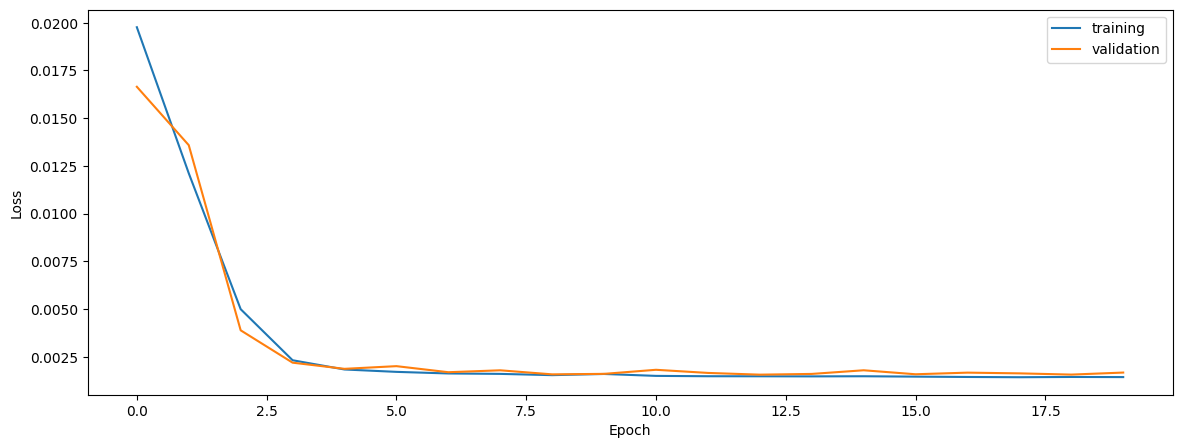

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9410653516767845
0.9529867852359871
0.9501436341448132


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getPearson(train2[1],train_pred2))
print(getPearson(val2[1],val_pred2))
print(getPearson(test2[1],test_pred2))

native
0.9410653516767845
0.9529867852359871
0.9501436341448132


In [9]:
print('normalized')
print(getPearson(train2[1][train2[2]],train_pred2[train2[2]]))
print(getPearson(val2[1][val2[2]],val_pred2[val2[2]]))
print(getPearson(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.9482605676989668
0.955904125265741
0.9624199584930615


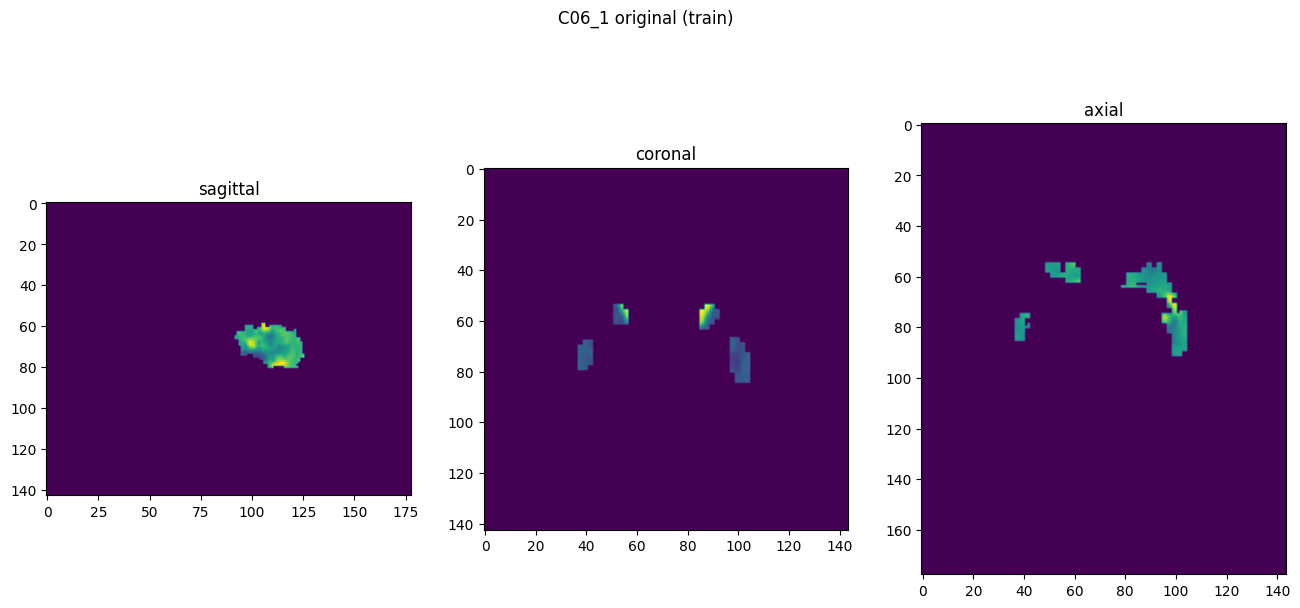

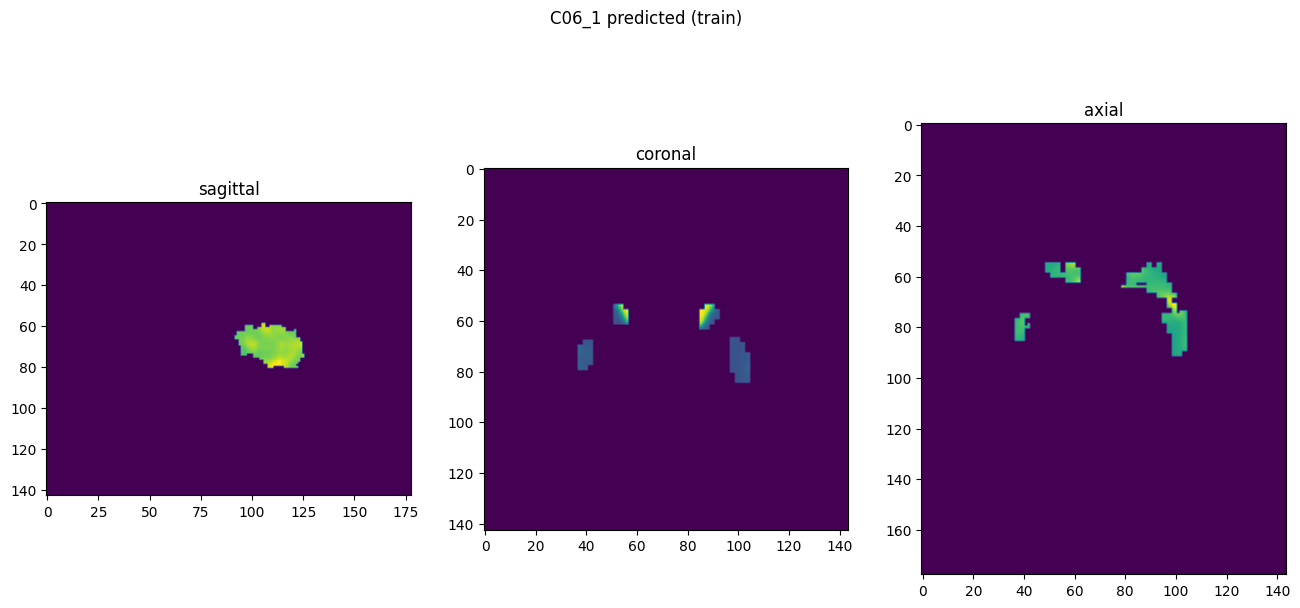

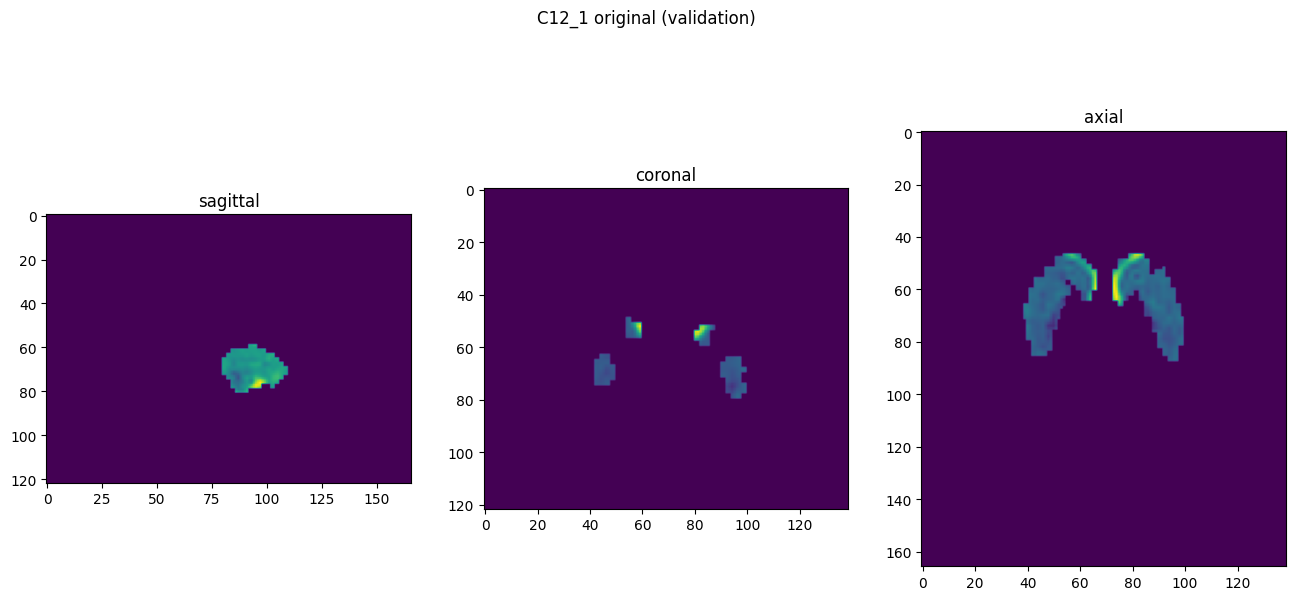

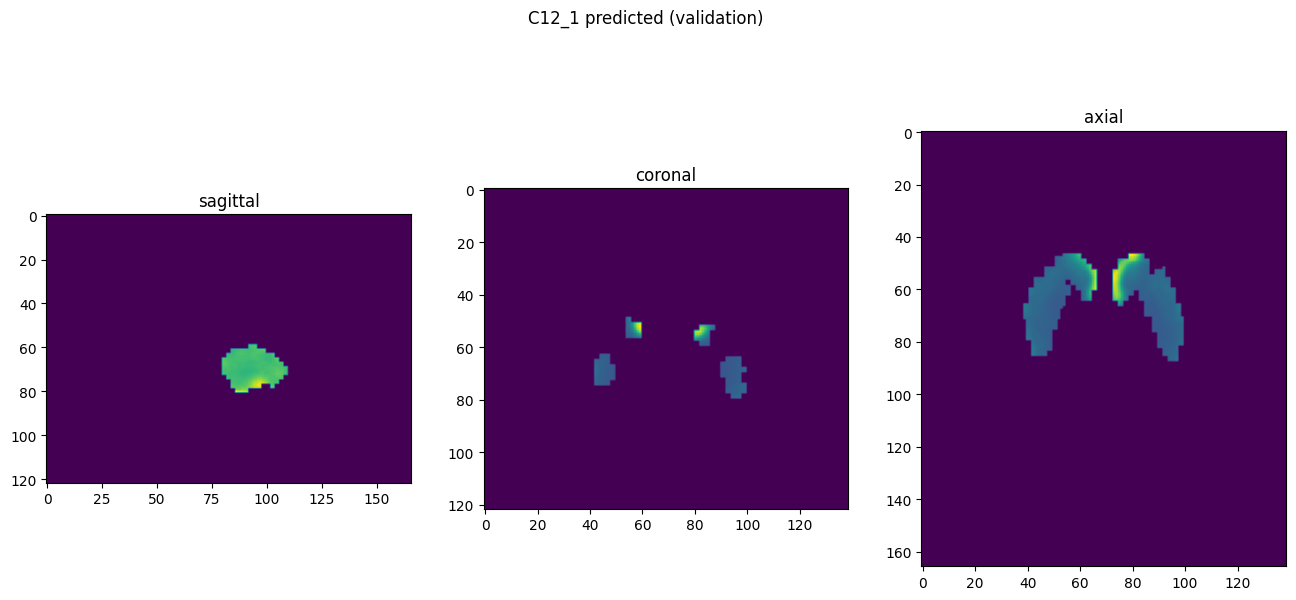

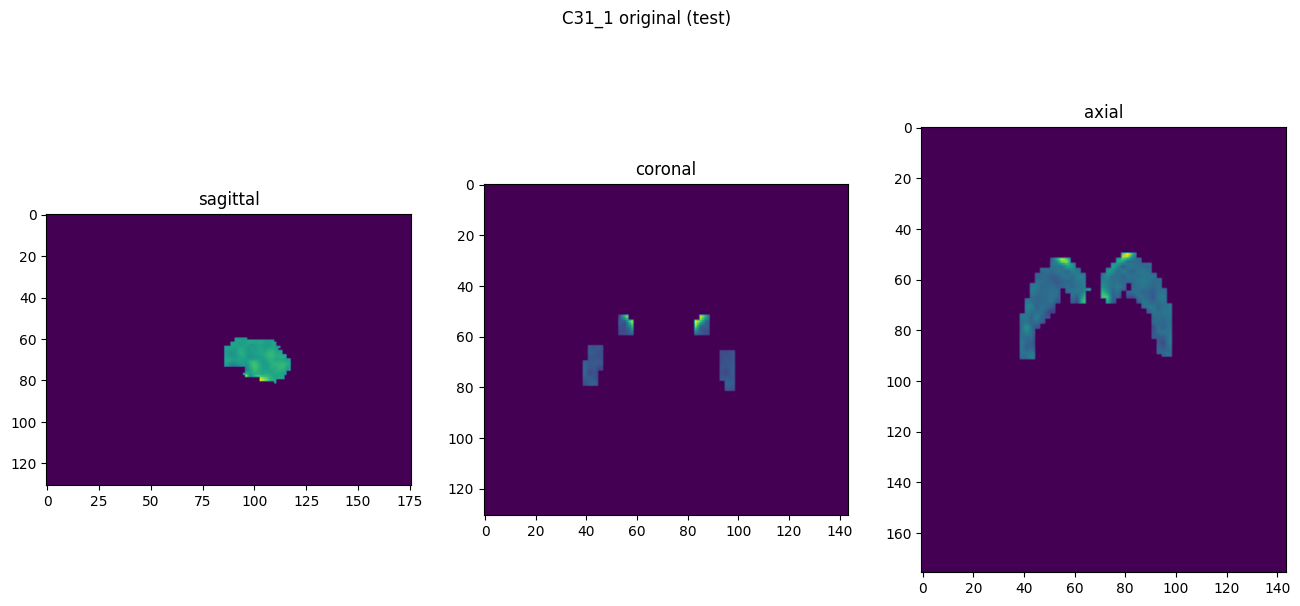

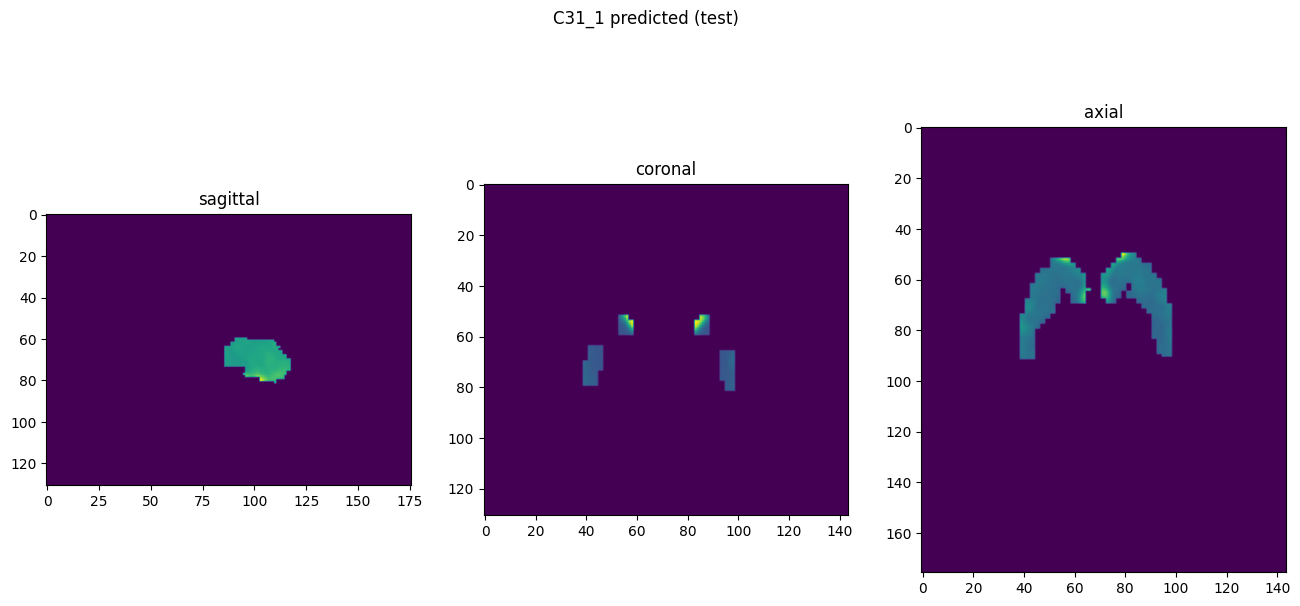

In [10]:
showResults(model, gen, threshold=None, background=False)